# 大作业要求

1.大作业以2-3人为一组完成，提交材料包括PPT（最后一次课将会展示课程成果）+ 最终的大作业报告（需组内各成员单独提交，内容为本人在课程大作业中的贡献以及对大作业问题的思考) + 提交包含分工情况及组内各成员工作量占比的表格。分工表格需组内所有成员签字确认；

2.禁止抄袭，发现雷同，所有雷同提交分数除以2；

3.写清楚大作业中的贡献和创新点，若使用开源代码和论文中的方法，在报告中必须注明（不可作为本人创新点），发现不标注引用，分数除以2。

最后一次课展示说明：
1.样例
PPT例子：https://www.sohu.com/a/166633625_642762
2.展示时间限制：
展示时间为最后一节课，展示时间为6分钟讲+2分钟同学助教老师自由提问

大作业报告：强调个人对问题的理解，以及贡献，建议增加在提问反馈之后的改进结果。

最终评分为:30%展示评分+70%大作业报告

# 问题描述(Out-of-Distribution)

深度神经网络通常采用独立同分布(Independent-Identically)的假设进行训练，即假设测试数据分布与训练数据分布相似。然而，当用于实际任务时，这一假设并不成立，导致其性能显著下降。虽然这种性能下降对于产品推荐等宽容性大的应用是可以接受的，但在医学等宽容性小的领域使用此类系统是危险的，因为它们可能导致严重事故。理想的人工智能系统应尽可能在分布外（Out-of-Distribution）的情况下有较强的分部外泛化能力。而提高分布外泛化的关键点，就是如何让模型学习到数据中的causal feature。  
一个简单的例子：以猫狗二分类为例，如果训练集中所有狗都在草地上，所有的猫都在沙发上，而测试集中所有的狗在沙发上，所有的猫在草地上，那么模型在没有测试集信息的情况下，很有可能根据训练集的信息把草地和狗联系在了一起，沙发和猫联系在了一起，当模型在测试集上测试时将会把在沙发上的狗误认为是猫。

# 数据集(Colored MNIST)

Colored MNIST是一个分布外泛化领域中常用的数据集，在该数据集中，训练集和测试集之间存在Out-of-Distribution情况，color feature和数字产生了spurious correlation，即虚假的因果关系。从直观上来说，数字的形状为causal feature，数字的颜色为non-causal feature。该次大作业旨在探索如何让模型学习到causal feature来提高泛化能力。

In [2]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [3]:
def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr,
                              np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,
                              np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """

    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

    def __getitem__(self, index):
        """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)

            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

            # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

            # Flip the color with a probability e that depends on the environment
            if idx < 20000:
                # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.1:
                    color_red = not color_red
            else:
                # 90% in the test environment
                if np.random.uniform() < 0.9:
                    color_red = not color_red

            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 20000:
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 40000:
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                test_set.append((Image.fromarray(colored_arr), binary_label))

            # Debug
           #print('original label', type(label), label)
            #print('binary label', binary_label)
            #print('assigned color', 'red' if color_red else 'green')
            #plt.imshow(colored_arr)
            #plt.show()
            #break

        if not os.path.exists(colored_mnist_dir): os.mkdir(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

# 初级部分：数据预处理

1.在Colored MNIST上训练和测试LeNet。  
2.在数据读取过程中增加数据预处理的方式（数据增广等），提高OOD泛化能力 【若选做高级部分可以跳过】

【OOD算法性能评价准则：在训练过程中只能接触训练集，不能在测试集上进行调参或者模型选择】

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 2 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 6*6 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [23]:


train1=ColoredMNIST(env='train1',transform=transforms.ToTensor())
train=ColoredMNIST(env='all_train',transform=transforms.ToTensor())
test=ColoredMNIST(env='test',transform=transforms.ToTensor())
train1loader = torch.utils.data.DataLoader(train1, batch_size=128,
                                          shuffle=True, num_workers=0)
trainloader = torch.utils.data.DataLoader(train, batch_size=128,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test, batch_size=10000,
                                          shuffle=False, num_workers=0)

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists


In [25]:
net = Net().cuda()
optimizer=optim.SGD(net.parameters(),0.01,0.9)
trainloss=[]
testacc=[]
for data in testloader:
            testimages, testlabels = data
            testimages=testimages.cuda()
            testlabels=testlabels.to(torch.float).cuda()
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels=labels.to(torch.float)
        # zero the parameter gradients
        optimizer.zero_grad()
        inputs=inputs.cuda()
        # forward + backward + optimize
        outputs = net(inputs).to('cpu').reshape(-1)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        trainloss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        outputs = (net(testimages)>0.5).float().reshape(-1)
        testacc_=((outputs == testlabels)).float().mean() 
        testacc.append(testacc_.item())

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
        

print('Finished Training')

[1,   200] loss: 0.578
[2,   200] loss: 0.414
[3,   200] loss: 0.399
Finished Training


In [7]:
torch.cuda.empty_cache()

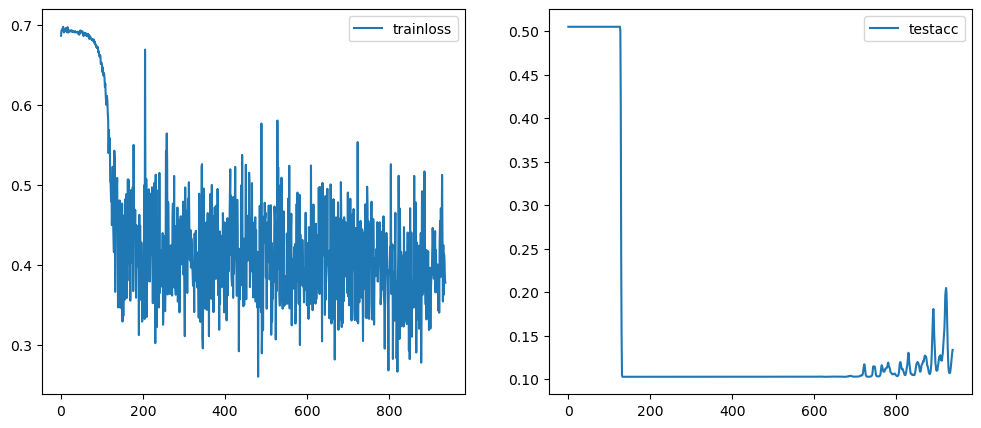

In [28]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from matplotlib import pyplot as plt
plt.figure(figsize=[12.,5.])
ax=plt.subplot(1,2,1)
ax.plot(trainloss,label='trainloss')
ax.legend()
ax=plt.subplot(1,2,2)
ax.plot(testacc,label='testacc')
ax.legend()
plt.show()


In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda()).cpu()
        predicted = outputs.data.map_(outputs.data,lambda x,_: 1 if x>0.5 else 0)
        predicted= predicted.reshape(10000)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 13 %


# 中级部分：算法复现

https://github.com/facebookresearch/DomainBed  
1.复现Invariant Risk Minimization (IRM)算法。  
2.从以下论文中选择一个OOD算法复现，思考什么样的算法可以在此数据集上取得较好效果。  
    - Domain-Adversarial Training of Neural Networks (DANN)    
    - Out-of-Distribution Generalization via Risk Extrapolation (VREx)  
    - Learning Explanations that are Hard to Vary (AndMask)  
    - Self-Challenging Improves Cross-Domain Generalization (RSC)   
3.IRM算法对penalty weight参数较为敏感，如何改进，提高IRM算法稳定性。

# 高级部分：探索OOD算法

证明、分析算法的因果推理能力和收敛性。